# Advanced Lane Finding Project

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
- Video pipeline

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
from collections import deque
%matplotlib inline

# Step 1: Compute the camera calibration matrix and distortion coefficients

In [2]:
# Loading camera calibration
calibrationImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), glob.glob('./camera_cal/c*.jpg')))
objpoints = []
imgpoints = []
outimages = []
originalImages = []

objp = np.zeros((6*9,3), np.float32) 
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x and y cordinates.

for imageAndFile in calibrationImages:
    fileName, image = imageAndFile
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        cornerPointsImg = cv2.drawChessboardCorners(image.copy(), (9,6), corners, ret)
        
        #Save output images to filesystem
        outFileName = fileName[12:]
        outFileName = './output_images/step1/' + outFileName
        cv2.imwrite(outFileName, cornerPointsImg)
        
        outimages.append(cornerPointsImg)
        originalImages.append(image)





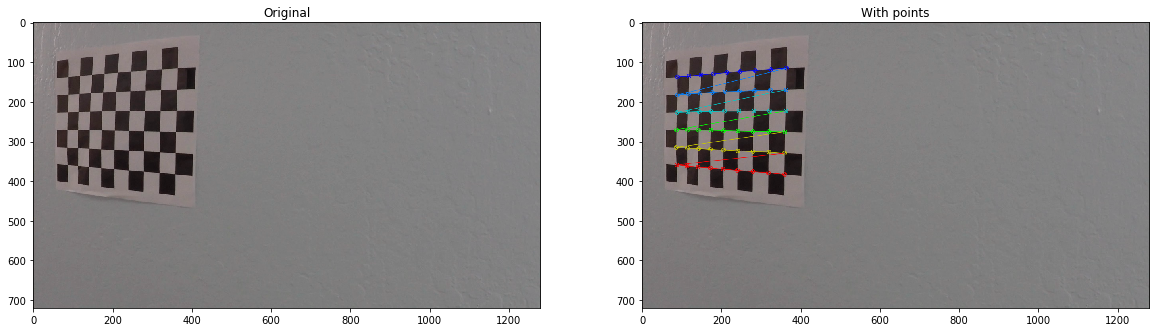

In [3]:
#example showing one of the original calibration input image and its corresponding distortion-corrected
index = 5
original = originalImages[index]
chessPoints = outimages[index]
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(original)
axes[0].set_title('Original')
axes[1].imshow(chessPoints)
axes[1].set_title('With points')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, original.shape[0:2], None, None)

# Step 2: Apply a distortion correction to raw images.

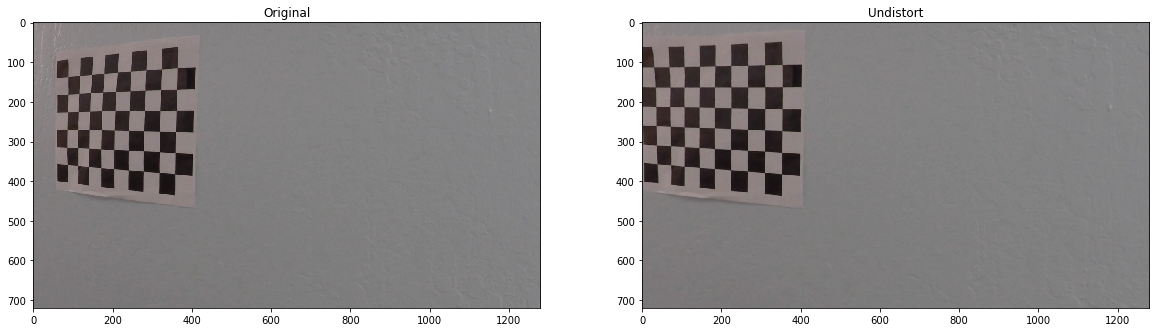

In [4]:
undist = cv2.undistort(original, mtx, dist, None, mtx)
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(original)
axes[0].set_title('Original')
axes[1].imshow(undist)
axes[1].set_title('Undistort')

# Step 3: Use color transforms, Sobel gradients to create a thresholded binary image.


In [5]:
def edgeDetectSobel(originalImg, imageName='', debug=0):
    """
    Raw image is preprocessed by converting it to HLS representation and S channel is extracted out
    upon which further processing is done to extract the edges by taking Sobel gradients in x and y directions
    and then combined to create a thresholded binary image showing only the edges in the image
    """
    
    # First step in edge detection pipeline is to undistort the image 
    # using the Camera Calibration matrix and distortion coefficients obtained from Step 1 In [3]
    undistortedImage = cv2.undistort(originalImg, mtx, dist, None, mtx)
    
    #Next is color transform, conversion from RGB to HLS and extract only SChannel to work with
    originalHLS = cv2.cvtColor(undistortedImage, cv2.COLOR_BGR2HLS)
    originalSChannel = originalHLS[:,:,2]
    
    
    # Calculate the Sobel gradient on the x and y directions using `sobel_kernel` as Sobel kernel size of 3.
    kernelSz = 3
    originalSobelX = cv2.Sobel(originalSChannel, cv2.CV_64F, 1, 0, kernelSz)
    originalSobelY = cv2.Sobel(originalSChannel, cv2.CV_64F, 0, 1, kernelSz)
 
    # Detect both edges - output image from the Sobel function has signed values
    # (positive and negative slopes) representing black to white transitions 
    # and white to black transitions. Therefore the absolute values are taken and then scaled
    # back to unsigned 8 bit image from CV_64F datatype
    absoluteSobelX = np.absolute(originalSobelX)
    absoluteSobelY = np.absolute(originalSobelY)   

    scaledSobelX = np.uint8(255.0 * absoluteSobelX/np.max(absoluteSobelX))
    scaledSobelY = np.uint8(255.0 * absoluteSobelY/np.max(absoluteSobelY))
    
    # Output from above step which has x and y gradients is passed to a thresholding
    # function to get a binary image 
    thresh_min = 10
    thresh_max = 160
    
    binarySobelX = applyThresholds(absoluteSobelX, thresh_min, thresh_max)
    binarySobelY = applyThresholds(absoluteSobelY, thresh_min, thresh_max)
    
    # To generate a single gradients image, both x and y images from previous step
    # is combined and returned as output image
    combined = np.zeros_like(binarySobelX) 
    combined[((binarySobelX == 1) & (binarySobelY == 1))] = 1
    
    if debug == 1:
        # Visualize the input, gradients and combined output image    
        fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
        axes[0].imshow(cv2.cvtColor(originalImg, cv2.COLOR_BGR2RGB))
        axes[0].set_title(imageName)
        axes[1].imshow(combined, 'gray')
        axes[1].set_title('Sobel Output')   
        
    return combined

def detectLaneLines(image, imageName='', show=False):
    """
    Raw image is preprocessed by converting it to HLS representation and very simple lane line detection method based on combination of yellow and white colors.
    -> The B channel from LAB with thresholds between 150 and 200 for extracting Yellow lines
    -> The L channel from LUV with thresholds between 255 and 255 for extracting white lines
    """    
    # First step in edge detection pipeline is to undistort the image 
    # using the Camera Calibration matrix and distortion coefficients obtained from Step 1 In [3]
    img = cv2.undistort(image, mtx, dist, None, mtx)
   
    #To extract white lines, the L channel from LUV with thresholds between 225 and 255
    lChannel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    #To extract yellow lines, the B channel from LAB with thresholds between 150 and 200
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    
    bThreshMin = 155
    bThreshMax = 200
    bBinary = applyThresholds(b_channel, bThreshMin, bThreshMax)
    
    lThreshMin = 225
    lThreshMax = 255
    lBinary = applyThresholds(lChannel, lThreshMin, lThreshMax)

    combinedBinary = np.zeros_like(lBinary)
    combinedBinary[(lBinary == 1) | (bBinary == 1)] = 1

    if show == True:
        # Plotting thresholded images
        fig, axes = plt.subplots(ncols=4, figsize=(10, 5))
        axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0].set_title(imageName)
        axes[1].imshow(lBinary, 'gray')
        axes[1].set_title('L binary threshold')
        axes[2].imshow(bBinary, 'gray')
        axes[2].set_title('B binary threshold')
        axes[3].imshow(combinedBinary, 'gray')
        axes[3].set_title('Combined Ouput')                
        
    return combinedBinary
    
def applyThresholds(img, thresh_min, thresh_max):
    """
    Applies a threshold to the `img` using [`thresh_min`, `thresh_max`] returning a binary image [0, 255]
    """
    xbinary = np.zeros_like(img)
    xbinary[(img >= thresh_min) & (img <= thresh_max)] = 1
    return xbinary

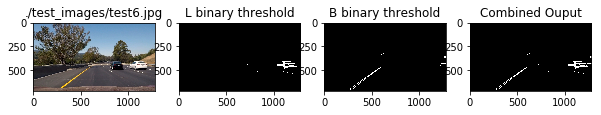

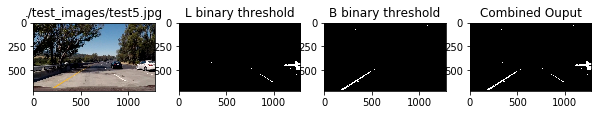

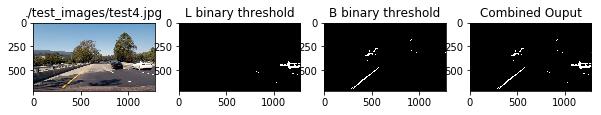

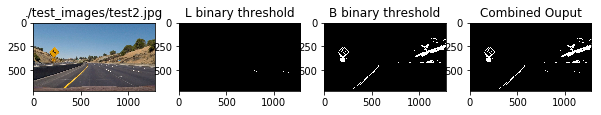

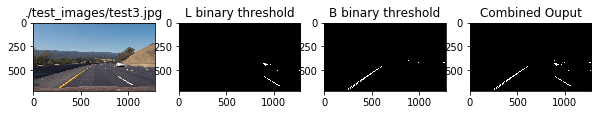

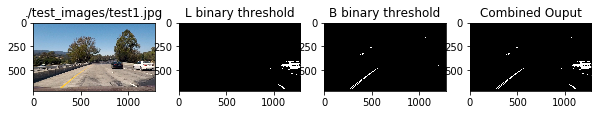

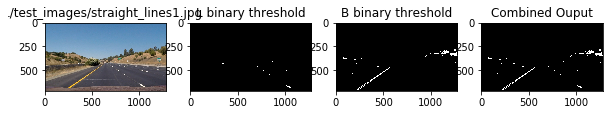

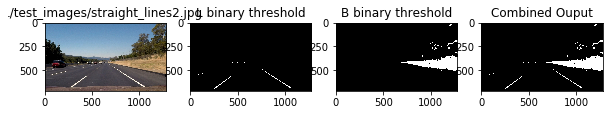

In [6]:
# Load test images.
testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.glob('./test_images/*.jpg')))

edgeDetectOutputImages = []
# Run edge detection pipeline for the given set of test images
for imageWithName in testImages:
    debugEnable = 1
    imageName, image = imageWithName
    #edgeDetectOutput = edgeDetectSobel(image, imageName, debugEnable)  
    edgeDetectOutput = detectLaneLines(image, imageName, True)
    #Save output images to filesystem
    outFileName = imageName[14:-4]    
    outFileName = './output_images/step3/' + outFileName + '.png'
    #print(outFileName)
    plt.imsave(outFileName, edgeDetectOutput, cmap = 'gray')
    
    edgeDetectOutputImages.append(edgeDetectOutput) 


# Step 4: Apply a perspective transform to rectify binary image ("birds-eye view").


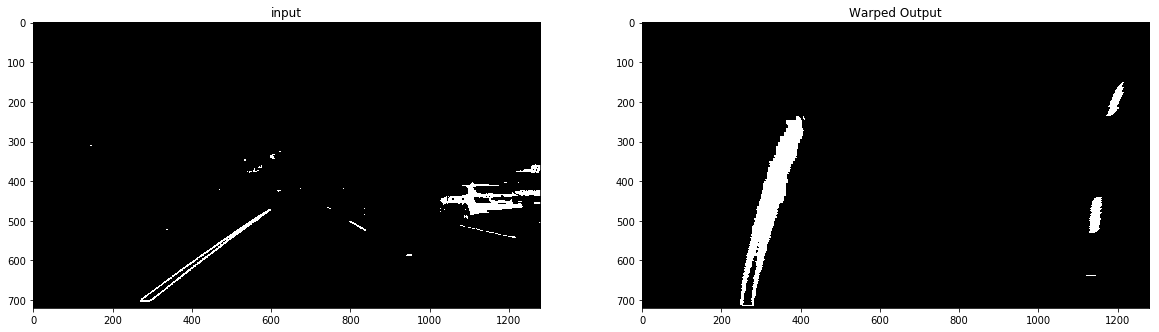

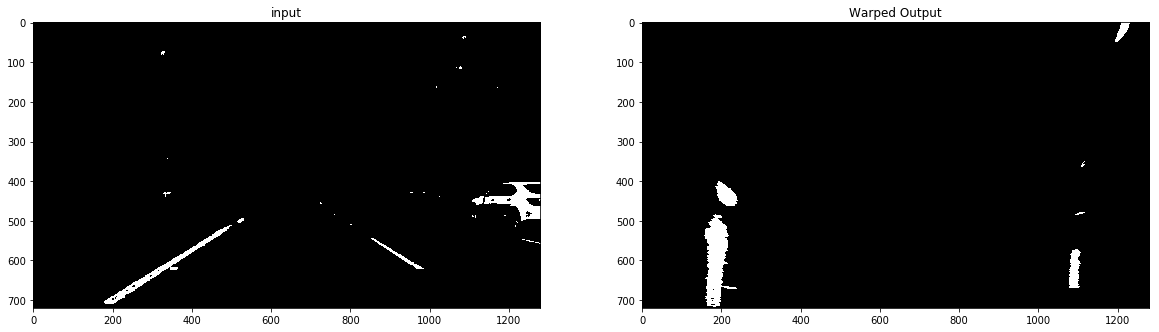

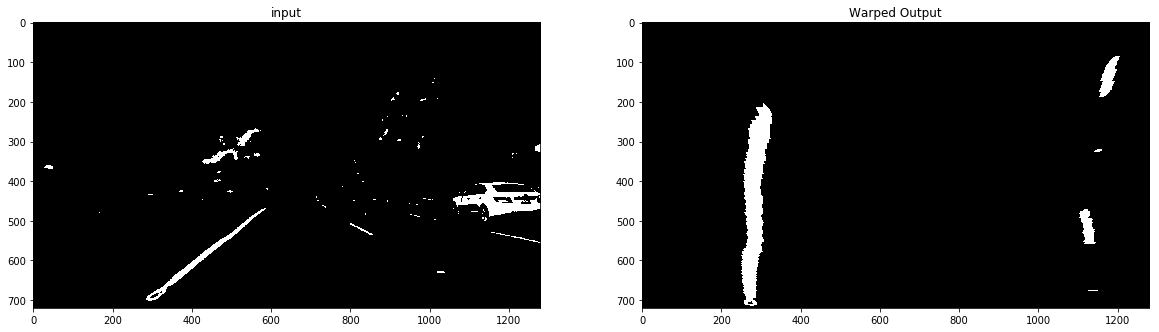

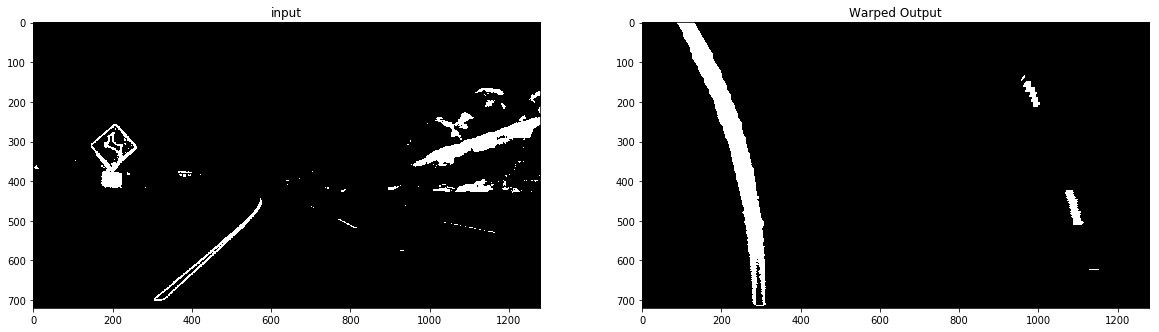

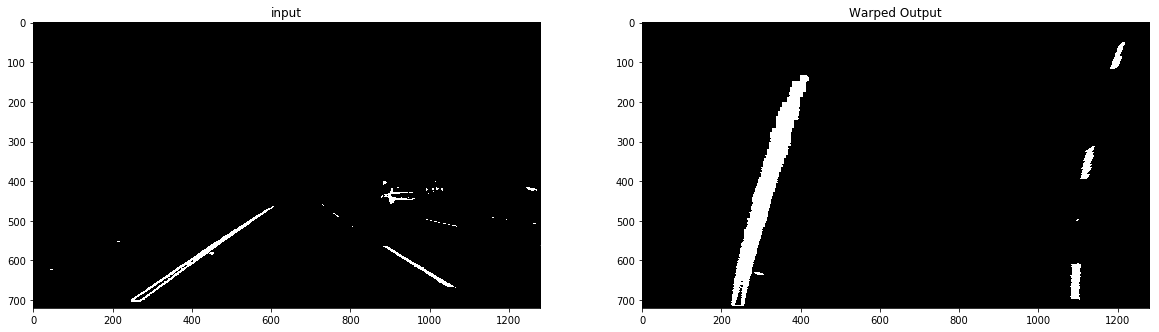

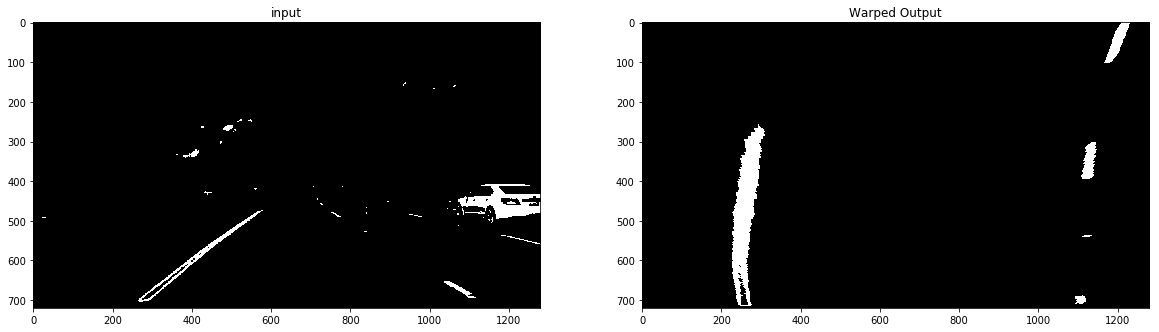

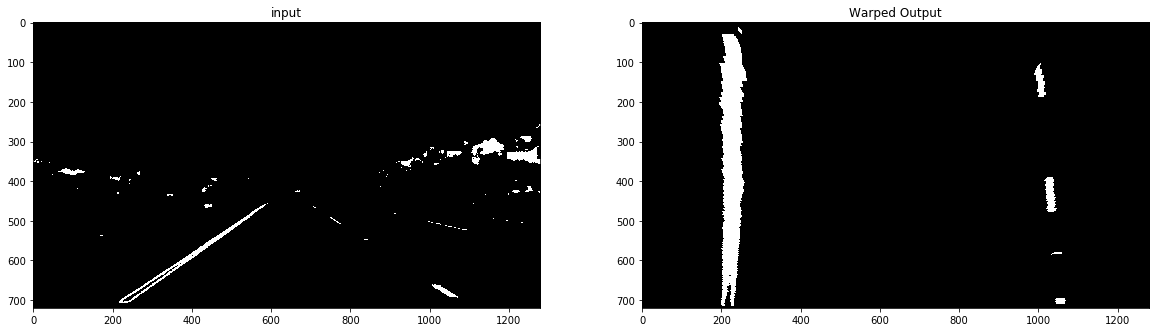

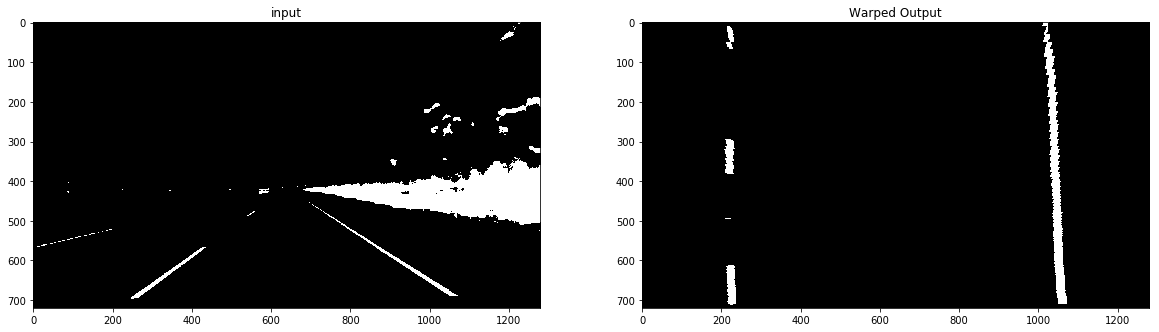

In [7]:
def applyPerspectiveTransform(binaryImage, cnt=0, debug=0):
    """
    This function applies perspective transform on portion lane lines set by 
    fixed pixel points describing the Region of Interest for Perspective transform
    """
    bottomY = 720
    topY = 455

    left1 = (190, bottomY)
    left1X, left1Y = left1
    
    left2 = (585, topY)
    left2X, left2Y = left2

    right1 = (705, topY)
    right1X, right1Y = right1

    right2 = (1130, bottomY)
    right2X, right2Y = right2

    src = np.float32([ 
        [left2X, left2Y],
        [right1X, right1Y],
        [right2X, right2Y],
        [left1X, left1Y]
    ])

    imgSz = (binaryImage.shape[1], binaryImage.shape[0])
    offset = 200
    dst = np.float32([
        [offset, 0],
        [imgSz[0] - offset, 0],
        [imgSz[0] - offset, imgSz[1]], 
        [offset, imgSz[1]]
    ])

    perspectiveMtx = cv2.getPerspectiveTransform(src, dst)
    perspectiveMtxInv = cv2.getPerspectiveTransform(dst, src)
    
    warpedImg = cv2.warpPerspective(binaryImage, perspectiveMtx, imgSz)
    
    if debug == 1:
        # Visualize the input, gradients and combined output image    
        fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
        axes[0].imshow(binaryImage, 'gray')
        axes[0].set_title('input')
        axes[1].imshow(warpedImg, 'gray')
        axes[1].set_title('Warped Output')

        #Save output images to filesystem
        outFileName = imageName[14:-4]  
        outFileName = './output_images/step4/warped_out' + str(cnt) + '.png'    
        #print(outFileName)
        plt.imsave(outFileName, warpedImg, cmap = 'gray')        
    return warpedImg, perspectiveMtxInv

cnt = 0
# Run edge detection pipeline for the given set of test images
# followed by perspective transform
for image in edgeDetectOutputImages:
    debugEnable = 1
    cnt += 1
    warpedImg, perspectiveMtxInv = applyPerspectiveTransform(image, cnt, debugEnable)

# Step 5: Detect lane pixels and fit to find the lane boundary.

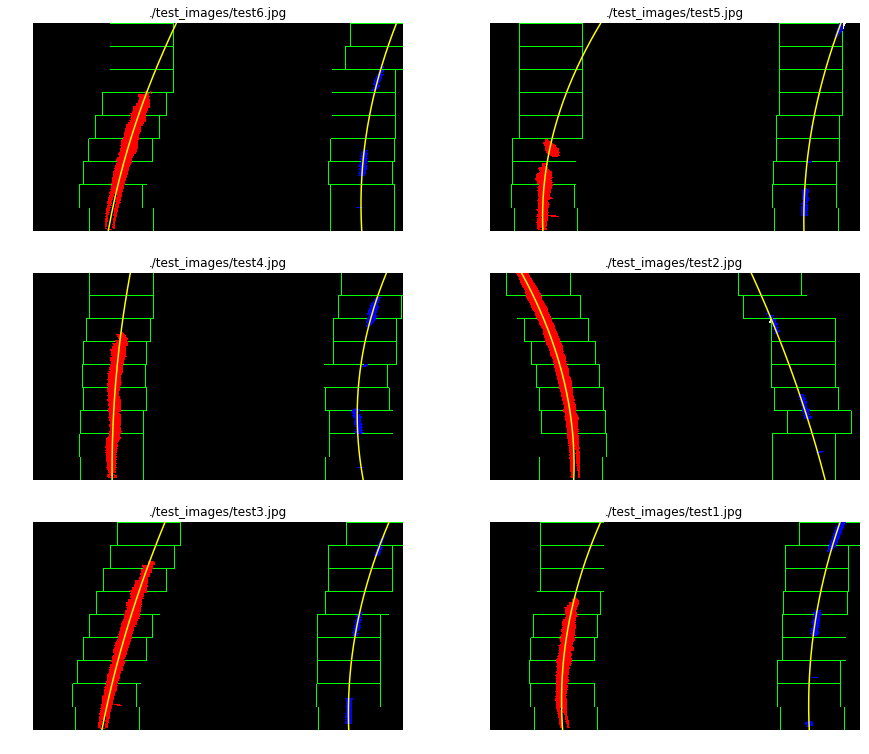

In [8]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def findLines(image, nwindows=9, margin=110, minpix=50):
    """
    Find the polynomial representation of the lines in the `image` using:
    - `nwindows` as the number of windows.
    - `margin` as the windows margin.
    - `minpix` as minimum number of pixes found to recenter the window.
    - `ym_per_pix` meters per pixel on Y.
    - `xm_per_pix` meters per pixels on X.
    
    Returns (left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)
    """    
    # Make a binary and transform image
    binary_image = detectLaneLines(image)
    binary_warped, perspectiveMtxInv = applyPerspectiveTransform(binary_image)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if len(leftx > 0) & len(lefty > 0) & len(rightx) & len(righty):
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
        # Fit a second order polynomial to each
        left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
        return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)   

def visualizeLanes(image, imagePathName, ax):
    """
    Visualize the windows and fitted lines for `image`.
    Returns (`left_fit` and `right_fit`)
    """
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findLines(image)
    # Visualization
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ax.imshow(out_img)
    
    #Save output images to filesystem
    outFileName = imagePathName[14:-4]    
    outFileName = './output_images/step5/' + outFileName + '.png'
    #print(outFileName)
    plt.imsave(outFileName, out_img, cmap = 'gray')
    
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    return ( left_fit, right_fit, left_fit_m, right_fit_m )

def showLaneOnImages(images, cols = 2, rows = 3, figsize=(15,13)):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    Returns a collection with the image paths and the left and right polynomials.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    imageAndFit = []
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            left_fit, right_fit, left_fit_m, right_fit_m = visualizeLanes(image, imagePathName, ax)
            ax.set_title(imagePathName)
            ax.axis('off')
            imageAndFit.append( ( imagePathName, left_fit, right_fit, left_fit_m, right_fit_m ) )
    return imageAndFit

imagesPoly = showLaneOnImages(testImages)

# Step 6: Determine the curvature of the lane and vehicle position with respect to center.

In [9]:
def calculateCurvature(yRange, left_fit_cr):
    """
    Returns the curvature of the polynomial `fit` on the y range `yRange`.
    """
    
    return ((1 + (2*left_fit_cr[0]*yRange*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

for imagePoly in imagesPoly:
    imagePath, left_fit, right_fit, left_fit_m, right_fit_m = imagePoly
    yRange = 719
    leftCurvature = calculateCurvature(yRange, left_fit_m) / 1000
    rightCurvature = calculateCurvature(yRange, right_fit_m) / 1000
    print('Image : {}, Left : {:.2f} km, Right : {:.2f} km'.format(imagePath, leftCurvature, rightCurvature))
    

Image : ./test_images/test6.jpg, Left : 0.79 km, Right : 0.53 km
Image : ./test_images/test5.jpg, Left : 0.37 km, Right : 0.60 km
Image : ./test_images/test4.jpg, Left : 1.22 km, Right : 0.39 km
Image : ./test_images/test2.jpg, Left : 0.40 km, Right : 1.18 km
Image : ./test_images/test3.jpg, Left : 1.09 km, Right : 0.51 km
Image : ./test_images/test1.jpg, Left : 0.46 km, Right : 0.61 km


# Step 7: Warp the detected lane boundaries back onto the original image.

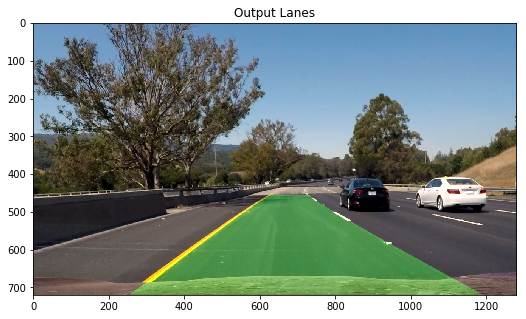

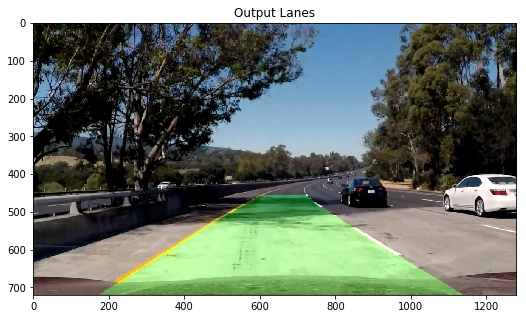

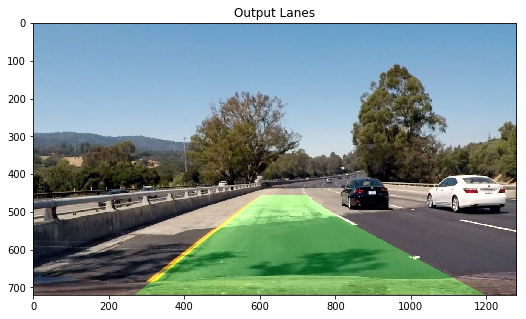

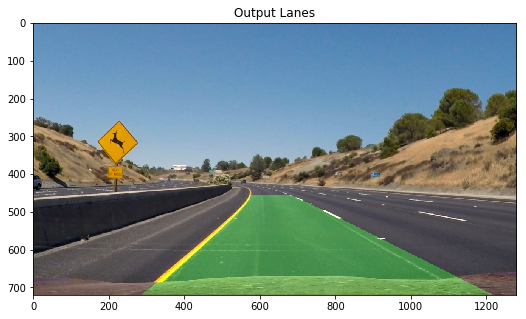

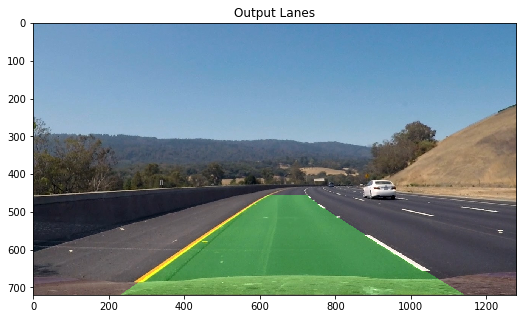

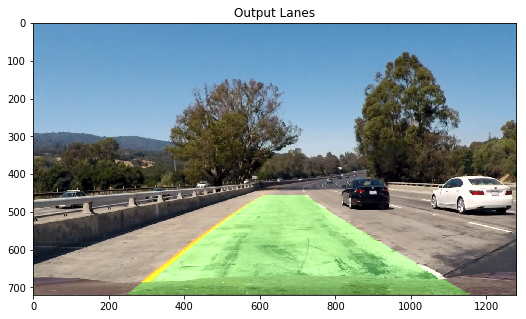

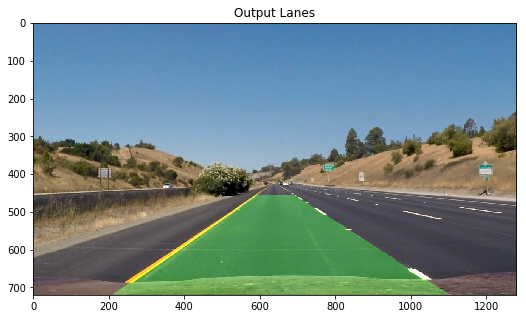

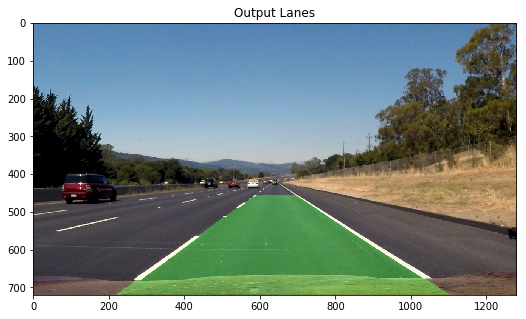

In [10]:
def drawLine(img, left_fit, right_fit):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspectiveMtxInv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

def drawLaneOnImage(imageName, img):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(img)
    output = drawLine(img, left_fit, right_fit)
    fig, axes = plt.subplots(ncols=1, figsize=(10, 5))
    axes.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axes.set_title('Output Lanes') 
    #Save output images to filesystem
    outFileName = imageName[14:-4]    
    outFileName = './output_images/step7/' + outFileName + '.png'
    #print(outFileName)
    plt.imsave(outFileName, cv2.cvtColor(output, cv2.COLOR_BGR2RGB), cmap = 'gray')    
    return cv2.cvtColor( output, cv2.COLOR_BGR2RGB )

# Run edge detection pipeline for the given set of test images
for imageWithName in testImages:
    imageName, image = imageWithName
    drawLaneOnImage(imageName, image)

# Step 8: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

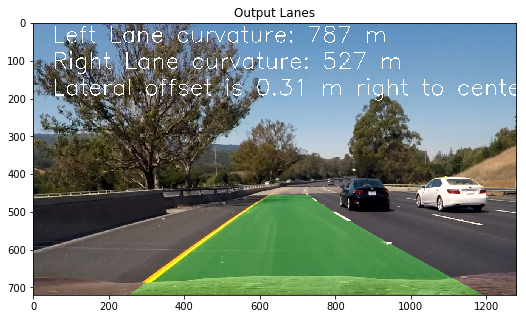

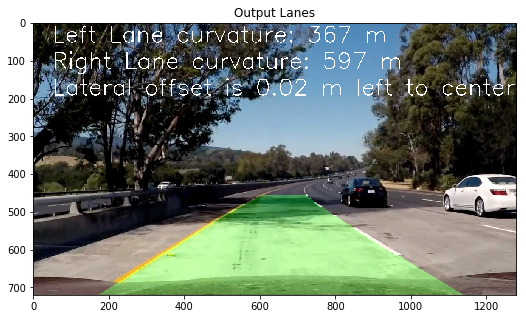

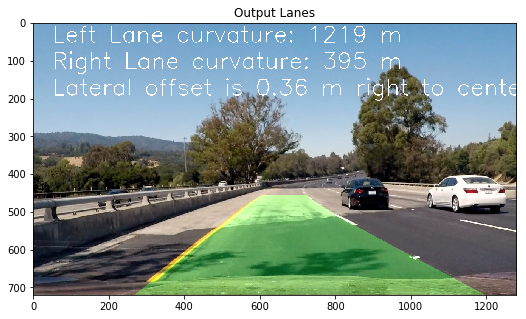

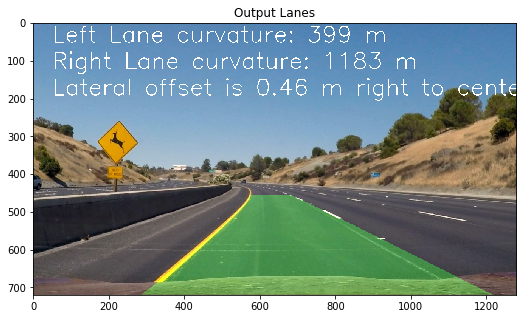

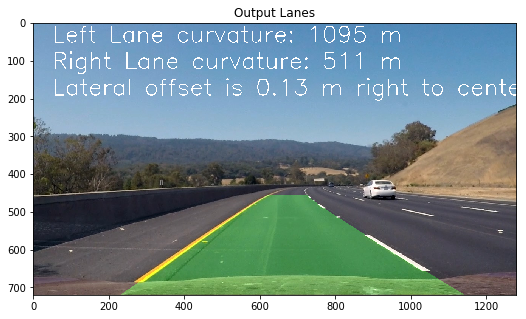

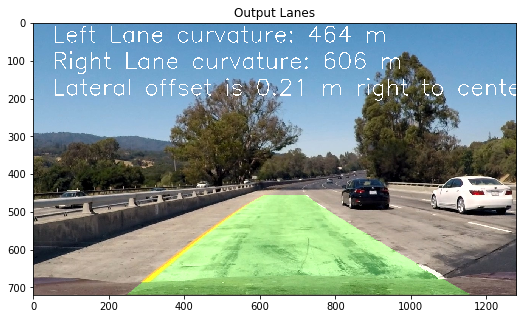

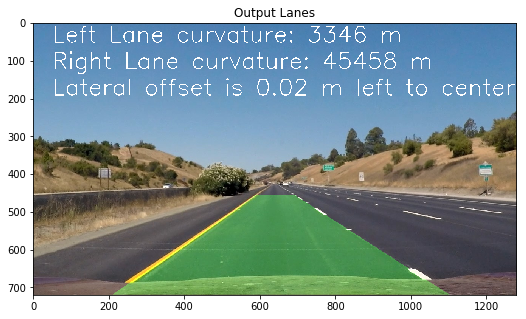

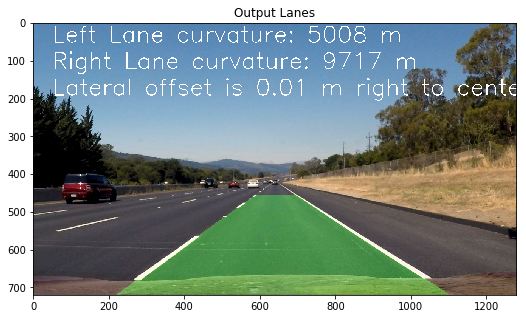

In [11]:
def pipeline(imageName, img, fontScale=2):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(img)
    output = drawLine(img, left_fit, right_fit)
    

    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)

    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    leftBoundary = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    rightBoundary = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    centerLine = leftBoundary + (rightBoundary - leftBoundary)/2
    diffFromVehicle = centerLine - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)

    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left Lane curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Right Lane curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Lateral offset is {} to center line'.format(message), (50, 190), font, fontScale, fontColor, 2)
    fig, axes = plt.subplots(ncols=1, figsize=(10, 5))
    axes.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axes.set_title('Output Lanes')     
    #Save output images to filesystem
    outFileName = imageName[14:-4]    
    outFileName = './output_images/step8/' + outFileName + '.png'
    #print(outFileName)
    plt.imsave(outFileName, cv2.cvtColor(output, cv2.COLOR_BGR2RGB), cmap = 'gray')    
    
    return output

for imageWithName in testImages:
    imageName, image = imageWithName
    pipeline(imageName, image)

# Step 9: Video pipeline

In [12]:
class Line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def brute_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top  

# Video Processing Pipeline
def processImage(image):
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perform perspective transform
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)

            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.brute_search(x, y, combined_binary)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.brute_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    Left.count += 1
    return result

from moviepy.editor import VideoFileClip    
def videoPipeline(input_video, output_video):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute and vehicle position information and
    generate `outputVideo`
    """
    #input_clip = VideoFileClip(input_video).subclip(0,3)
    input_clip = VideoFileClip(input_video)
    out_clip = input_clip.fl_image(processImage) 
    out_clip.write_videofile(output_video, audio=False)  
    
Left = Line()
Right = Line()
  
# Project video
videoPipeline('project_video.mp4', 'project_video_out.mp4')

#Left = Line()
#Right = Line()
#videoPipeline('challenge_video.mp4', 'challenge_video_out.mp4')

#Left = Line()
#Right = Line()
#videoPipeline('harder_challenge_video.mp4', 'harder_challenge_video_out.mp4')    

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [23:24<00:01,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 



In [14]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_video_out.mp4'))